In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import tensorflow as tf
from tensorflow import keras
from skimage import transform
import os
import imageio
import PIL
import time

dimensions: (128, 128, 4)
min_px: 0.054901961237192154
max_px: 1.0


C:\Users\hashi\AppData\Local\Temp\ipykernel_9516\2901457391.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


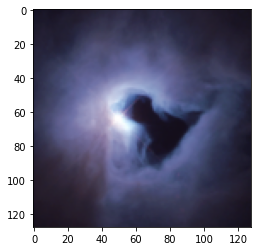

In [2]:
# util functions for reading .tif/.png imgs

# takes a path for a .png format img and returns it as a np.ndarray
def read_img(path: str):
    try:
        img = plt.imread(path)
        return img
        
    except FileNotFoundError:
        print(f'unable to read path: {path} from the current directory')
        raise FileNotFoundError

# crop/resize .png format img to n x n x 3 img 
# default n = 256 so imgs are reformated to row: 128 col: 128 channels: 3 
def resize_img(img: np.ndarray, n: int=128):
    try:
        row, col, ch = img.shape

        scale = max(n / row, n / col)
        img = transform.rescale(img, scale, multichannel=True)
        return img[:n, :n, :]

    except:
        return f'unable to resize {*img.shape,} to 128, 128, 4'


# void function to graph a .png img to a matplotlib plot
def display_img(img: np.ndarray, cmap: str=None):
    plt.imshow(img) if not cmap else plt.imshow(img, cmap=cmap)

    try:
        row, col, ch = img.shape
    except:
        row, col = img.shape
        
    print(f'dimensions: {img.shape}\nmin_px: {np.min(img)}\nmax_px: {np.max(img)}')


# example for reading and resizing a .png image from hubble_imgs and graphing it
img = read_img(r'./hubble_imgs_fixed/opo0010a.png')
img = resize_img(img)

display_img(img)


In [3]:
# UNPROCESSED DATA FROM KAGGLE: https://www.kaggle.com/datasets/redwankarimsony/top-100-hubble-telescope-images?resource=download
# had to delete some of the larger imgs from the dataset

# process training data from m,n,3 .tif imgs to 128,128,3 png imgs 
# commented out because i alr processed the data and deleted ./hubble_imgs 
# .tif img directory because it was taking up 4gbs of space
# for path in os.listdir(r'./hubble_imgs'):
#     read, write = os.path.join('hubble_imgs', path), os.path.join('hubble_imgs_fixed', path[:-4] + '.png')

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

# resizing images to 128, 128, 4 because 256, 256, 4 was too large
# for path in os.listdir(r'./hubble_imgs_fixed'):
#     read, write = os.path.join('./hubble_imgs_fixed', path), os.path.join('./hubble_imgs_fixed', path)

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

In [4]:
# reformating data into a csv *not really ideal the csv is very large so not really useable
# function which returns the csv header
def csv_header():
    repr = ''

    for row in range(128):
        for col in range(128):
            for channel in ('r', 'g', 'b', 'a'):
                repr += f'{row}x{col}{channel},'

    return repr[:-1]



# read data from directory *dirname into a formated processed csv
def imgs_to_csv(dirname: str, dest: str='hubble_data.csv'):
    try:
        # append each flattened img in hubble_img_fixed to hubble_imgs.csv file 
        with open(dest, 'ab') as csvstream:
            for img in os.listdir(dirname):
                img = read_img(os.path.join(dirname, img))
                # each channel *rgb has px values ranging from 0 to 1 as a floating pt num i.e x.xxxxxx
                np.savetxt(csvstream, img.reshape(1,128*128*4), fmt='%1.6f', delimiter=',') 

    
    except FileNotFoundError:
        print(f'unable to find directory: {dirname}')

# imgs_to_csv('./hubble_imgs_fixed')
# img_df = pd.DataFrame(read_img('./hubble_imgs_fixed/opo0010a.png')[:, :, 0])
# print(img_df)
# print(csv_header())

Found 96 files belonging to 1 classes.
dimensions: (128, 128, 3)
min_px: 0.027450980618596077
max_px: 0.8941176533699036


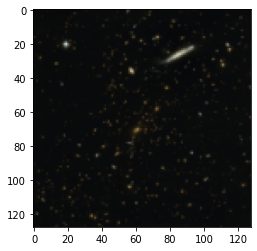

In [5]:
# reads training/sample data to a ndarray~ and sets hyperparameters 

BUFFER_SIZE = 99
BATCH_SIZE = 11

IMG_DIM = 128, 128, 3   # shape of img tensors
NUM_FILTERS = 64        # number of kernels/filters applied to conv2d layer
FILTER_SIZE = 4         # size of kernel/filter matrix for conv2d layers
LATENT_DIM = 100        # size of normally distributed random input tensors for generator

LEARNING_RATE = 0.0001    # dcgan hyperparameter
ALPHA = 0.2             # cnn hyperparameter for discriminator and generator not really sure what this means

TRAIN = keras.preprocessing.image_dataset_from_directory(
    'hubble_imgs_fixed', label_mode=None, image_size=(128, 128), batch_size=BATCH_SIZE
)

# train is a tensorflow.python.data.ops.dataset_ops.MapDataset object *not ndarray
# ndarray of 96 tensors of dim 128, 128, 3 *96 rgb imgs
# batches of size BATCH_SIZE
# px values normalized to range [0, 1]
TRAIN = TRAIN.map(lambda px: px / 255.0)
 
for batch in TRAIN:
    png = batch.numpy().astype('float32')[0]
    display_img(png)
    break



In [6]:
# discriminator/classifier function for the gan
# downsamples and maxpools 128, 128, 4 tensors representing rgba imgs to a probability between 0 and 1 that the img is real
def make_discriminator(img_dim=IMG_DIM, num_filters=NUM_FILTERS, num_layers=4):
    model = keras.Sequential(name='discriminator')

    # input/img layer 128, 128, 3 tensor with values in range [0, 1]
    model.add(keras.layers.Input(shape=img_dim))

    # hidden convolutional layers downscale tensor/img to 2**(7-num_layers) by 2**(7-num_layers) in this case 16x16
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(num_filters, kernel_size=FILTER_SIZE, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU(alpha=ALPHA))
    
    # flatten the leftover img tensor
    model.add(keras.layers.Flatten())
    
    # output layer probability in range [0, 1] that img is real or fake
    model.add(keras.layers.Dropout(ALPHA))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

untrained decision: [[0.48274955]]
dimensions: (128, 128)
min_px: 0.49867385625839233
max_px: 0.5017223954200745


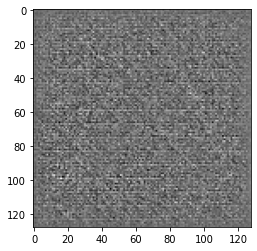

In [7]:
# generator function for the gan
# upsamples a normally distributed 100, 1 tensor to 256, 256, 4 tensors representing rgba img
def make_generator(latent_dim=LATENT_DIM, num_filters=NUM_FILTERS, num_layers=4):
    model = keras.Sequential()

    # input/latent layer 100, 1 tensor with values normally distributed in the range [0, 1]
    model.add(keras.layers.Input(shape=(latent_dim,)))
    model.add(keras.layers.Dense(8 * 8 * 64))
    model.add(keras.layers.Reshape((8, 8, 64)))

    # num_layers hidden convolutional layers to upsample image to 256, 256, 4 rgba img
    for _ in range(num_layers):
        model.add(keras.layers.Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU(alpha=ALPHA))
        num_filters *= 2

    # output layer
    model.add(keras.layers.Conv2DTranspose(3, kernel_size=5, padding='same', activation='sigmoid'))

    return model


# make neural networks for generator and discriminator
# no loss function yet *will use binarycrossentropy
generator = make_generator()
discriminator = make_discriminator()

# discriminator.summary()
# generator.summary()

noise = tf.random.uniform([1, 100])
generated_img = generator(noise, training=False)
print(f'untrained decision: {discriminator(generated_img)}')
display_img(generated_img[0, :, :, 2], cmap='gray')

In [8]:
# referece to understand whats going on: https://keras.io/examples/generative/dcgan_overriding_train_step/
# default to using a generator which takes a normally distributed 1, 100 tensor and creates rgb imgs of dim 1, 128, 128, 3
# default to using a discriminator which takes a rgb img of dim 1, 128, 128, 3 and returns a probability in the range [0, 1]


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANmonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=LATENT_DIM):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [17]:
# # trains the dcgan
# # sets up checkpoints to train gan over multiple sessions
# ckpt_dir = './training_checkpoints'
# ckpt_path = os.path.join(ckpt_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(
#   generator_optimizer=generator_optimizer, 
#   discriminator_optimizer=discriminator_optimizer,
#   generator=generator,discriminator=discriminator
#   )
# ckpt_manager = tf.train.CheckpointManager(checkpoint, ckpt_path, max_to_keep=4)
# checkpoint.restore(ckpt_manager.latest_checkpoint)
EPOCHS = 80

dcgan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
dcgan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    g_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn = keras.losses.BinaryCrossentropy()
)

dcgan.fit(
    TRAIN, epochs=EPOCHS, callbacks=[GANmonitor(num_img=1, latent_dim=LATENT_DIM)]
)

Epoch 1/80
9/9 [==============================] - 32s 3s/step - d_loss: 0.6284 - g_loss: 2.1121
Epoch 2/80
9/9 [==============================] - 34s 4s/step - d_loss: 1.1284 - g_loss: 1.0815
Epoch 3/80
9/9 [==============================] - 33s 4s/step - d_loss: 1.1648 - g_loss: 0.4298
Epoch 4/80
9/9 [==============================] - 33s 4s/step - d_loss: 0.6890 - g_loss: 0.5708
Epoch 5/80
9/9 [==============================] - 33s 4s/step - d_loss: 0.5888 - g_loss: 0.7112
Epoch 6/80
9/9 [==============================] - 41s 5s/step - d_loss: 0.6415 - g_loss: 0.5946
Epoch 7/80
9/9 [==============================] - 78s 9s/step - d_loss: 0.6258 - g_loss: 0.8054
Epoch 8/80
9/9 [==============================] - 71s 8s/step - d_loss: 0.5665 - g_loss: 1.1088
Epoch 9/80
9/9 [==============================] - 49s 5s/step - d_loss: 0.4568 - g_loss: 1.3306
Epoch 10/80
9/9 [==============================] - 48s 5s/step - d_loss: 0.4056 - g_loss: 1.5369
Epoch 11/80
9/9 [======================

trained decision: [[0.69837826]]
dimensions: (128, 128, 3)
min_px: 1.0386729996057775e-13
max_px: 0.619800865650177


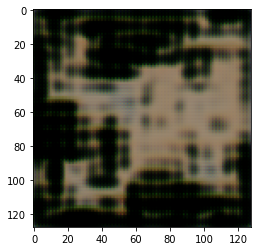

In [86]:
# issue with overfitting / possibly not enough data only had 96 training samples
# note the generated_imgs start from epoch 31 because i lost the first 30 epochs 
# around epoch 60ish (30 in generated imgs dir) the images looked organic but the nn looks overfitted after around 80 (50 in generated imgs dir) epochs
# may also be an issue with hyperparameters of dcgan
reloaded_generator = tf.saved_model.load('./generator_nn.tf')

def generate_random():
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    print(f'trained decision: {discriminator(generated_image)}')
    display_img(generated_image[0, :, :, :])

generate_random()

In [87]:
# making gif of epochs [30, 110] not including 110th epoch
dirname = './generated_imgs/'
gif = []
for png in os.listdir(dirname):
    gif.append(imageio.imread(f'{dirname}{png}'))

imageio.mimsave('./timelapse.gif', gif, duration=0.17)

# saving the generator nn to be able to use later
# tf.saved_model.save(generator, './generator_nn.tf')

C:\Users\hashi\AppData\Local\Temp\ipykernel_9516\3059010104.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif.append(imageio.imread(f'{dirname}{png}'))
